# Instâncias reais

* **timestamp**: observations timestamps loaded into pandas DataFrame as its index;
* **P-PDG**: pressure variable at the Permanent Downhole Gauge (PDG);
* **P-TPT**: pressure variable at the Temperature and Pressure Transducer (TPT);
* **T-TPT**: temperature variable at the Temperature and Pressure Transducer (TPT);
* **P-MON-CKP**: pressure variable upstream of the production choke (CKP);
* **T-JUS-CKP**: temperature variable downstream of the production choke (CKP);
* **P-JUS-CKGL**: pressure variable upstream of the gas lift choke (CKGL);
* **T-JUS-CKGL**: temperature variable upstream of the gas lift choke (CKGL);
* **QGL**: gas lift flow rate;
* **class**: observations labels associated with three types of periods (normal, fault transient, and faulty steady state).


* **label**: instance label (event type);
* **well**: well name. Hand-drawn and simulated instances have fixed names. Real instances have names masked with incremental id;
* **id**: instance identifier. Hand-drawn and simulated instances have incremental id. Each real instance has an id generated from its first timestamp.

## Treinamento de modelos sem anomalias no conjunto de treino

https://github.com/petrobras/3W

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import json
from time import time
import joblib
import pickle

from pyod.models.ecod import ECOD

from pyod.models.suod import SUOD

from pyod.models.xgbod import XGBOD

from pyod.models.loda import LODA

from pyod.models.pca import PCA

from pyod.models.iforest import IForest


from itertools import product


# import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDOneClassSVM
from sklearn.pipeline import make_pipeline
from sklearn.svm import OneClassSVM

from sklearn.model_selection import GroupKFold

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics  import average_precision_score, make_scorer, roc_curve,f1_score, precision_score, recall_score, fbeta_score, auc, roc_auc_score, accuracy_score, confusion_matrix, classification_report,precision_recall_curve
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

### Function to calculate metrics

In [2]:
def metrics(y_test, y_pred):
    cm = list()
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm)                      
    plt.figure(figsize=(8,6))  
    sns.heatmap(cm_df, annot=True)
    print("Classification Report: \n", classification_report(y_test, y_pred, digits=5))  


    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]

    print("Specificity:", TN/(TN+FP))


    roc_auc_s = roc_auc_score(y_test, y_pred)
    gini = 2*roc_auc_s -1
    print("Gini: ",gini)
    print("ROC AUC:: ",roc_auc_s)

## Read data

In [3]:
train = pd.read_parquet('./dataset/train_temp.parquet.gzip') 
test = pd.read_parquet('./dataset/test_temp.parquet.gzip') 

In [4]:
VARS = ['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'QGL']

In [5]:
development = train.reset_index(drop=True)
development.shape

(8887177, 10)

In [6]:
train_no_anomalies = train[train.target==0]
train_no_anomalies.shape

(5872276, 10)

In [7]:
class ToDataFrameTransformer(BaseEstimator, TransformerMixin):
    """
    Transformador para converter arrays NumPy em DataFrames, mantendo os nomes das colunas.
    """
    def __init__(self, columns=None):
        self.columns = columns
    
    def fit(self, X, y=None):
        # Não há nada para ajustar, apenas retorna o próprio objeto
        return self

    def transform(self, X):
        # Converte o array NumPy em DataFrame com os nomes das colunas fornecidos
        if self.columns is not None:
            return pd.DataFrame(X, columns=self.columns)
        return pd.DataFrame(X)

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)
    

def convert_param_grid(param_grid):
    param_grid_formatted = []
    
    # Gerar todas as combinações possíveis dos parâmetros usando itertools.product
    for combination in product(*param_grid.values()):
        params_dict = {key: value for key, value in zip(param_grid.keys(), combination)}
        param_grid_formatted.append({'params': params_dict})
    
    return param_grid_formatted


def cross_validation(estimator_class, param_grid, dataset, tscv, features, scikit = False, random_state=None):

    results = list()

    param_list = convert_param_grid(param_grid)

    # Iterar sobre todas as combinações de hiperparâmetros
    for params in param_list:
                    
        split_scores = {
            'f1_score': [],
            'specificity': [],
            'precision': [],
            'recall': [],
            'roc_auc':[],
            # 'pr_auc':[],
            'fit_time': [],
            'score_time': []
        }

        if estimator_class==SGDOneClassSVM:

            transform = Nystroem(gamma=None, random_state=42)
            estimator = estimator_class(random_state=random_state, **params['params'])
            estimator = make_pipeline(transform, estimator)


        else:
            if random_state==None:
                estimator = estimator_class(**params['params'])
            else:
                estimator = estimator_class(random_state=random_state, **params['params'])

        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('to_dataframe', ToDataFrameTransformer(columns=features)),
            ('estimator', estimator)
        ])

        # TimeSeriesSplit
        for fold_idx, (train_index, test_index) in enumerate(tscv.split(dataset)):
            X_train_split = dataset[dataset.index.isin(train_index)]
            X_train_split = X_train_split[X_train_split.target==0]

            X_test_split = dataset[dataset.index.isin(test_index)]

            if X_test_split.target.mean()>0:
                print("taxa de anomalias:",  X_test_split.target.mean())
                start_fit = time()
                pipeline.fit(X_train_split[features])
                fit_time = time() - start_fit

                
                start_score = time()
                y_pred_split = pipeline.predict(X_test_split[features])
                score_time = time() - start_score

                # y_scores = pipeline.decision_function(X_test_split[features])


                if scikit==True:
                    y_pred_split = np.where(y_pred_split == -1, 1, 0)  
                
                y_true_split = X_test_split.target.values
                
                precision = precision_score(y_true_split, y_pred_split, zero_division=0)
                recall = recall_score(y_true_split, y_pred_split, zero_division=0)
                f1 = f1_score(y_true_split, y_pred_split, zero_division=0)
                try:
                    roc_auc = roc_auc_score(y_true_split, y_pred_split)

                except:
                    roc_auc = 0
                # pr_auc = average_precision_score(y_true_split, y_scores)
                
                if len(np.unique(y_true_split)) == 2 and len(np.unique(y_pred_split)) == 2:
                    tn, fp, fn, tp = confusion_matrix(y_true_split, y_pred_split).ravel()
                else:
                    tn, fp, fn, tp = (0, 0, 0, 0)

                specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
                
                split_scores['f1_score'].append(f1)
                split_scores['specificity'].append(specificity)
                split_scores['precision'].append(precision)
                split_scores['recall'].append(recall)
                split_scores['roc_auc'].append(roc_auc)
                # split_scores['pr_auc'].append(pr_auc)
                split_scores['fit_time'].append(fit_time)
                split_scores['score_time'].append(score_time)
            else:
                continue    

        results.append({
            'params': params['params'],
            'fold_scores': {
                'test_f1_scores': split_scores['f1_score'],
                'test_specificities': split_scores['specificity'],
                'test_precisions': split_scores['precision'],
                'test_recalls': split_scores['recall'],
                'test_roc_auc': split_scores['roc_auc'],
                # 'test_pr_auc': split_scores['pr_auc'],
                'fit_times': split_scores['fit_time'],
                'score_times': split_scores['score_time']
            },
            'mean_test_f1_score': np.mean(split_scores['f1_score']),
            'std_test_f1_score': np.std(split_scores['f1_score']),
            'mean_test_specificity': np.mean(split_scores['specificity']),
            'std_test_specificity': np.std(split_scores['specificity']),
            'mean_test_precision': np.mean(split_scores['precision']),
            'std_test_precision': np.std(split_scores['precision']),
            'mean_test_recall': np.mean(split_scores['recall']),
            'std_test_recall': np.std(split_scores['recall']),
            'mean_test_roc_auc': np.mean(split_scores['roc_auc']),
            'std_test_roc_auc': np.std(split_scores['roc_auc']),
            # 'mean_test_pr_auc': np.mean(split_scores['pr_auc']),
            # 'std_test_pr_auc': np.std(split_scores['pr_auc']),
            'mean_fit_time': np.mean(split_scores['fit_time']),
            'std_fit_time': np.std(split_scores['fit_time']),
            'mean_score_time': np.mean(split_scores['score_time']),
            'std_score_time': np.std(split_scores['score_time']),
        })
    results_df = pd.DataFrame(results)

    return results_df 

In [8]:
def create_pipeline_with_kernel(estimator_class, params, kernel=None, gamma=None, random_state=None):
    if kernel:
        transform = Nystroem(kernel=kernel, gamma=gamma, random_state=random_state)
        estimator = estimator_class(random_state=random_state, **params)
        estimator = make_pipeline(transform, estimator)
    else:
        estimator = estimator_class(random_state=random_state, **params)
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('to_dataframe', ToDataFrameTransformer(columns=VARS)),
        ('estimator', estimator)
    ])
    return pipeline


def cross_validation_ocsvm(estimator_class, param_grid, dataset, tscv, features, scikit=False, random_state=None, kernels=None):

    results = list()

    param_list = convert_param_grid(param_grid)

    # Iterar sobre todas as combinações de hiperparâmetros
    for params in param_list:
                    
        split_scores = {
            'f1_score': [],
            'specificity': [],
            'precision': [],
            'recall': [],
            'roc_auc':[],
            # 'pr_auc':[],
            'fit_time': [],
            'score_time': []
        }

        # Loop sobre kernels, se definidos
        for kernel in kernels or [None]:  # Se não houver kernel, apenas None
            print(f"Treinando com kernel: {kernel} e parâmetros: {params['params']}")
            
            pipeline = create_pipeline_with_kernel(
                estimator_class=SGDOneClassSVM if kernel else estimator_class,
                params=params['params'],
                kernel=kernel,
                random_state=random_state
            )

                    # TimeSeriesSplit
            for fold_idx, (train_index, test_index) in enumerate(tscv.split(dataset)):
                X_train_split = dataset[dataset.index.isin(train_index)]
                X_train_split = X_train_split[X_train_split.target==0]

                X_test_split = dataset[dataset.index.isin(test_index)]

                if X_test_split.target.mean()>0:
                    print("taxa de anomalias:",  X_test_split.target.mean())
                    start_fit = time()
                    pipeline.fit(X_train_split[features])
                    fit_time = time() - start_fit

                    
                    start_score = time()
                    y_pred_split = pipeline.predict(X_test_split[features])
                    score_time = time() - start_score

                    # y_scores = pipeline.decision_function(X_test_split[features])


                    if scikit==True:
                        y_pred_split = np.where(y_pred_split == -1, 1, 0)  
                    
                    y_true_split = X_test_split.target.values
                    
                    precision = precision_score(y_true_split, y_pred_split, zero_division=0)
                    recall = recall_score(y_true_split, y_pred_split, zero_division=0)
                    f1 = f1_score(y_true_split, y_pred_split, zero_division=0)
                    try:
                        roc_auc = roc_auc_score(y_true_split, y_pred_split)

                    except:
                        roc_auc = 0
                    # pr_auc = average_precision_score(y_true_split, y_scores)
                    
                    if len(np.unique(y_true_split)) == 2 and len(np.unique(y_pred_split)) == 2:
                        tn, fp, fn, tp = confusion_matrix(y_true_split, y_pred_split).ravel()
                    else:
                        tn, fp, fn, tp = (0, 0, 0, 0)

                    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
                    
                    split_scores['f1_score'].append(f1)
                    split_scores['specificity'].append(specificity)
                    split_scores['precision'].append(precision)
                    split_scores['recall'].append(recall)
                    split_scores['roc_auc'].append(roc_auc)
                    # split_scores['pr_auc'].append(pr_auc)
                    split_scores['fit_time'].append(fit_time)
                    split_scores['score_time'].append(score_time)
                else:
                    continue    

            results.append({
                'kernel':kernel,
                'params': params['params'],
                'fold_scores': {
                    'test_f1_scores': split_scores['f1_score'],
                    'test_specificities': split_scores['specificity'],
                    'test_precisions': split_scores['precision'],
                    'test_recalls': split_scores['recall'],
                    'test_roc_auc': split_scores['roc_auc'],
                    # 'test_pr_auc': split_scores['pr_auc'],
                    'fit_times': split_scores['fit_time'],
                    'score_times': split_scores['score_time']
                },
                'mean_test_f1_score': np.mean(split_scores['f1_score']),
                'std_test_f1_score': np.std(split_scores['f1_score']),
                'mean_test_specificity': np.mean(split_scores['specificity']),
                'std_test_specificity': np.std(split_scores['specificity']),
                'mean_test_precision': np.mean(split_scores['precision']),
                'std_test_precision': np.std(split_scores['precision']),
                'mean_test_recall': np.mean(split_scores['recall']),
                'std_test_recall': np.std(split_scores['recall']),
                'mean_test_roc_auc': np.mean(split_scores['roc_auc']),
                'std_test_roc_auc': np.std(split_scores['roc_auc']),
                # 'mean_test_pr_auc': np.mean(split_scores['pr_auc']),
                # 'std_test_pr_auc': np.std(split_scores['pr_auc']),
                'mean_fit_time': np.mean(split_scores['fit_time']),
                'std_fit_time': np.std(split_scores['fit_time']),
                'mean_score_time': np.mean(split_scores['score_time']),
                'std_score_time': np.std(split_scores['score_time']),
            })
    results_df = pd.DataFrame(results)

    return results_df 

In [9]:
def cross_validation_ratios(estimator_class, param_grid, dataset, fold_ratios, features, scikit = False, random_state=None):

    results = list()

    param_list = convert_param_grid(param_grid)

    # Iterar sobre todas as combinações de hiperparâmetros
    for params in param_list:
                    
        split_scores = {
            'f1_score': [],
            'specificity': [],
            'precision': [],
            'recall': [],
            'roc_auc':[],
            # 'pr_auc':[],
            'fit_time': [],
            'score_time': []
        }

        if estimator_class==SGDOneClassSVM:

            transform = Nystroem(gamma=None, random_state=42)
            estimator = estimator_class(random_state=random_state, **params['params'])
            estimator = make_pipeline(transform, estimator)


        else:
            if random_state==None:
                estimator = estimator_class(**params['params'])
            else:
                estimator = estimator_class(random_state=random_state, **params['params'])

        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('to_dataframe', ToDataFrameTransformer(columns=features)),
            ('estimator', estimator)
        ])

        # TimeSeriesSplit
        for ratios in fold_ratios:

            X_train_split = list()
            X_test_split = list()

            dataset = dataset.sort_values(by=['well', 'timestamp'])

            # Iterar sobre cada poco
            for poco_id, poco_data in dataset.groupby('well'):
                # Calcular o índice para dividir os dados em treinamento e teste
                split_index = int(ratios * len(poco_data))
                
                # Dividir os dados do poco em treinamento e teste
                poco_train = poco_data.iloc[:split_index]
                poco_test = poco_data.iloc[split_index:]
                
                # Adicionar os dados de treinamento e teste à lista
                X_train_split.append(poco_train)
                X_test_split.append(poco_test)

            # Concatenar os dados de treinamento e teste
            X_train_split = pd.concat(X_train_split)
            X_test_split = pd.concat(X_test_split)

            X_train_split = X_train_split[X_train_split.target==0]


            if X_test_split.target.mean()>0:
                print("taxa de anomalias:",  X_test_split.target.mean())
                start_fit = time()
                pipeline.fit(X_train_split[features])
                fit_time = time() - start_fit

                
                start_score = time()
                y_pred_split = pipeline.predict(X_test_split[features])
                score_time = time() - start_score

                # y_scores = pipeline.decision_function(X_test_split[features])


                if scikit==True:
                    y_pred_split = np.where(y_pred_split == -1, 1, 0)  
                
                y_true_split = X_test_split.target.values
                
                precision = precision_score(y_true_split, y_pred_split, zero_division=0)
                recall = recall_score(y_true_split, y_pred_split, zero_division=0)
                f1 = f1_score(y_true_split, y_pred_split, zero_division=0)
                try:
                    roc_auc = roc_auc_score(y_true_split, y_pred_split)
                except:
                    roc_auc = 0
                # pr_auc = average_precision_score(y_true_split, y_scores)
                
                if len(np.unique(y_true_split)) == 2 and len(np.unique(y_pred_split)) == 2:
                    tn, fp, fn, tp = confusion_matrix(y_true_split, y_pred_split).ravel()
                else:
                    tn, fp, fn, tp = (0, 0, 0, 0)

                specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
                
                split_scores['f1_score'].append(f1)
                split_scores['specificity'].append(specificity)
                split_scores['precision'].append(precision)
                split_scores['recall'].append(recall)
                split_scores['roc_auc'].append(roc_auc)
                # split_scores['pr_auc'].append(pr_auc)
                split_scores['fit_time'].append(fit_time)
                split_scores['score_time'].append(score_time)
            else:
                continue    

        results.append({
            'params': params['params'],
            'fold_scores': {
                'test_f1_scores': split_scores['f1_score'],
                'test_specificities': split_scores['specificity'],
                'test_precisions': split_scores['precision'],
                'test_recalls': split_scores['recall'],
                'test_roc_auc': split_scores['roc_auc'],
                # 'test_pr_auc': split_scores['pr_auc'],
                'fit_times': split_scores['fit_time'],
                'score_times': split_scores['score_time']
            },
            'mean_test_f1_score': np.mean(split_scores['f1_score']),
            'std_test_f1_score': np.std(split_scores['f1_score']),
            'mean_test_specificity': np.mean(split_scores['specificity']),
            'std_test_specificity': np.std(split_scores['specificity']),
            'mean_test_precision': np.mean(split_scores['precision']),
            'std_test_precision': np.std(split_scores['precision']),
            'mean_test_recall': np.mean(split_scores['recall']),
            'std_test_recall': np.std(split_scores['recall']),
            'mean_test_roc_auc': np.mean(split_scores['roc_auc']),
            'std_test_roc_auc': np.std(split_scores['roc_auc']),
            # 'mean_test_pr_auc': np.mean(split_scores['pr_auc']),
            # 'std_test_pr_auc': np.std(split_scores['pr_auc']),
            'mean_fit_time': np.mean(split_scores['fit_time']),
            'std_fit_time': np.std(split_scores['fit_time']),
            'mean_score_time': np.mean(split_scores['score_time']),
            'std_score_time': np.std(split_scores['score_time']),
        })
    results_df = pd.DataFrame(results)

    return results_df 

### Isolation Forest

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

In [9]:
# Definir a grade de hiperparâmetros para o IsolationForest
param_grid = {
    'n_estimators': [50, 100, 256],      # Número de árvores na floresta
    'max_samples': ['auto', 0.7, 1.0],     # Fração de amostras para treinamento de cada árvore
    'contamination': [0.05, 0.01, 0.001], # Fração de dados que são esperados ser outliers
    'max_features': [1.0, 0.7],             # Número de recursos (features) a serem considerados para dividir em cada nó
    'n_jobs': [-1]
}

estimator_class = IsolationForest

# Configurar TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)


In [11]:
results_df_iforest = cross_validation(estimator_class, param_grid, development, tscv, VARS, scikit = True, random_state=42)

taxa de anomalias: 0.16380006427238528
taxa de anomalias: 0.07884349314112829
taxa de anomalias: 0.6981308798205415
taxa de anomalias: 0.16380006427238528
taxa de anomalias: 0.07884349314112829
taxa de anomalias: 0.6981308798205415
taxa de anomalias: 0.16380006427238528
taxa de anomalias: 0.07884349314112829
taxa de anomalias: 0.6981308798205415
taxa de anomalias: 0.16380006427238528
taxa de anomalias: 0.07884349314112829
taxa de anomalias: 0.6981308798205415
taxa de anomalias: 0.16380006427238528
taxa de anomalias: 0.07884349314112829
taxa de anomalias: 0.6981308798205415
taxa de anomalias: 0.16380006427238528
taxa de anomalias: 0.07884349314112829
taxa de anomalias: 0.6981308798205415
taxa de anomalias: 0.16380006427238528
taxa de anomalias: 0.07884349314112829
taxa de anomalias: 0.6981308798205415
taxa de anomalias: 0.16380006427238528
taxa de anomalias: 0.07884349314112829
taxa de anomalias: 0.6981308798205415
taxa de anomalias: 0.16380006427238528
taxa de anomalias: 0.078843493141

In [12]:
results_df_iforest

,params,fold_scores,mean_test_f1_score,std_test_f1_score,mean_test_specificity,std_test_specificity,mean_test_precision,std_test_precision,mean_test_recall,std_test_recall,mean_test_roc_auc,std_test_roc_auc,mean_fit_time,std_fit_time,mean_score_time,std_score_time
0,"{'n_estimators': 50, 'max_samples': 'auto', 'c...","{'test_f1_scores': [0.8808118206138321, 0.2221...",0.639982,0.296575,0.461048,0.403331,0.575349,0.329739,0.948930,0.064690,0.704989,0.173729,9.657572,4.376885,4.275401,0.234156
1,"{'n_estimators': 50, 'max_samples': 'auto', 'c...","{'test_f1_scores': [0.7845335879602001, 0.2224...",0.609729,0.274301,0.431985,0.365777,0.490502,0.259162,0.997790,0.003126,0.714887,0.181493,10.289452,5.217440,4.983473,0.246042
2,"{'n_estimators': 50, 'max_samples': 'auto', 'c...","{'test_f1_scores': [0.4154704215049831, 0.0, 0...",0.161288,0.181890,0.666667,0.471405,0.666667,0.471405,0.099204,0.116162,0.549602,0.058081,8.826412,4.355622,4.493544,0.428209
3,"{'n_estimators': 50, 'max_samples': 'auto', 'c...","{'test_f1_scores': [0.699327916397875, 0.0, 0....",0.558174,0.410443,0.666667,0.471405,0.666667,0.471405,0.496419,0.389579,0.748210,0.194789,10.460227,5.507685,4.711985,0.270680
4,"{'n_estimators': 50, 'max_samples': 'auto', 'c...","{'test_f1_scores': [0.0, 0.0, 0.0], 'test_spec...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,7.843386,3.574903,4.064210,0.160139
5,"{'n_estimators': 50, 'max_samples': 'auto', 'c...","{'test_f1_scores': [0.06382622158025361, 0.0, ...",0.344538,0.442886,0.666667,0.471405,0.666667,0.471405,0.324772,0.436194,0.662386,0.218097,9.135723,4.458204,4.467646,0.171688
6,"{'n_estimators': 50, 'max_samples': 0.7, 'cont...","{'test_f1_scores': [0.2814917601414536, 0.2003...",0.436229,0.278185,0.116044,0.142513,0.326644,0.268255,1.000000,0.000000,0.558022,0.071256,46.770034,25.471758,7.709900,1.029663
7,"{'n_estimators': 50, 'max_samples': 0.7, 'cont...","{'test_f1_scores': [0.2814917601414536, 0.1991...",0.435410,0.277904,0.111451,0.141972,0.325776,0.267560,1.000000,0.000000,0.555725,0.070986,47.973920,24.160423,8.197011,1.107502
8,"{'n_estimators': 50, 'max_samples': 0.7, 'cont...","{'test_f1_scores': [0.2814917601414536, 0.2167...",0.443921,0.276754,0.152525,0.164805,0.333303,0.270141,1.000000,0.000000,0.576263,0.082402,47.086110,24.995009,8.171039,1.123908
9,"{'n_estimators': 50, 'max_samples': 0.7, 'cont...","{'test_f1_scores': [0.2814917601414536, 0.2143...",0.443636,0.278163,0.153035,0.159122,0.333568,0.271636,1.000000,0.000000,0.576518,0.079561,52.694319,27.184023,8.674500,0.789215


In [13]:
# Identificar a melhor combinação de hiperparâmetros
best_params_idx = results_df_iforest['mean_test_roc_auc'].idxmax()
best_params_idx
best_params = results_df_iforest.loc[best_params_idx]

print("\nMelhores parâmetros encontrados:", best_params['params'])

print("\nMétricas:", best_params)


Melhores parâmetros encontrados: {'n_estimators': 256, 'max_samples': 'auto', 'contamination': 0.01, 'max_features': 0.7, 'n_jobs': -1}

Métricas: params                   {'n_estimators': 256, 'max_samples': 'auto', '...
fold_scores              {'test_f1_scores': [0.8898413143878615, 0.0, 0...
mean_test_f1_score                                                 0.61587
std_test_f1_score                                                 0.436368
mean_test_specificity                                             0.666667
std_test_specificity                                              0.471405
mean_test_precision                                               0.666667
std_test_precision                                                0.471405
mean_test_recall                                                  0.573501
std_test_recall                                                   0.408349
mean_test_roc_auc                                                  0.78675
std_test_roc_auc           

In [11]:
estimator_iforest = IForest(random_state=42, n_estimators= 256, max_samples= 'auto', contamination= 0.01, max_features= 0.7, n_jobs= -1)

In [12]:
best_model_iforest2 = Pipeline([
            ('scaler', StandardScaler()),
            ('to_dataframe', ToDataFrameTransformer(columns=VARS)),
            ('estimator', estimator_iforest)
        ])

best_model_iforest2.fit(train_no_anomalies[VARS])

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['P-PDG', 'P-TPT', 'T-TPT',
                                                 'P-MON-CKP', 'T-JUS-CKP',
                                                 'P-JUS-CKGL', 'QGL'])),
                ('estimator',
                 IForest(behaviour='old', bootstrap=False, contamination=0.01,
    max_features=0.7, max_samples='auto', n_estimators=256, n_jobs=-1,
    random_state=42, verbose=0))])

In [13]:
y_pred = best_model_iforest2.predict(test[VARS])


y_test = test.target.values

Classification Report: 
               precision    recall  f1-score   support

           0    0.87907   0.99033   0.93138   1493608
           1    0.97320   0.72055   0.82803    728192

    accuracy                        0.90191   2221800
   macro avg    0.92613   0.85544   0.87971   2221800
weighted avg    0.90992   0.90191   0.89751   2221800

Specificity: 0.9903254401422595
Gini:  0.7108799092932527
ROC AUC::  0.8554399546466264


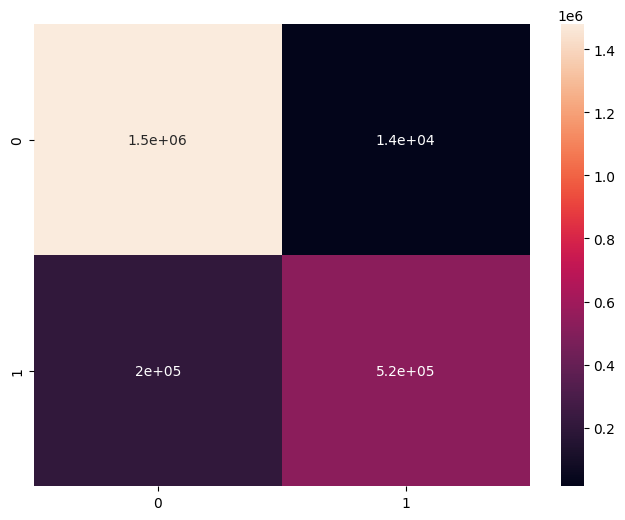

In [16]:
metrics(y_test, y_pred)

In [17]:
with open('./models/pipeline_iForest2.pkl', 'wb') as file: 
    pickle.dump(best_model_iforest2, file)

In [14]:
estimator = estimator_class(random_state=42, **best_params['params'])

best_model_iforest = Pipeline([
            ('scaler', StandardScaler()),
            ('to_dataframe', ToDataFrameTransformer(columns=VARS)),
            ('estimator', estimator)
        ])

best_model_iforest.fit(train_no_anomalies[VARS])

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['P-PDG', 'P-TPT', 'T-TPT',
                                                 'P-MON-CKP', 'T-JUS-CKP',
                                                 'P-JUS-CKGL', 'QGL'])),
                ('estimator',
                 IsolationForest(contamination=0.01, max_features=0.7,
                                 n_estimators=256, n_jobs=-1,
                                 random_state=42))])

In [15]:
best_model_iforest

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['P-PDG', 'P-TPT', 'T-TPT',
                                                 'P-MON-CKP', 'T-JUS-CKP',
                                                 'P-JUS-CKGL', 'QGL'])),
                ('estimator',
                 IsolationForest(contamination=0.01, max_features=0.7,
                                 n_estimators=256, n_jobs=-1,
                                 random_state=42))])

In [16]:
scale_iforest = best_model_iforest[0]
scale_iforest

StandardScaler()

In [17]:
media = scale_iforest.mean_

desvio_padrao = scale_iforest.scale_

print("Média calculada pelo StandardScaler:", media)
print("Desvio padrão calculado pelo StandardScaler:", desvio_padrao)

Média calculada pelo StandardScaler: [1.01713733e+07 1.32058831e+07 1.17294754e+02 4.47385646e+06
 7.32985921e+01 2.17328886e+06 1.96035520e-06]
Desvio padrão calculado pelo StandardScaler: [1.88216312e+07 5.09831214e+06 8.36684233e-01 3.90022108e+06
 1.16327041e+01 1.56808619e+06 2.93207414e-04]


In [18]:
y_pred = best_model_iforest.predict(test[VARS])
y_pred = np.where(y_pred == -1, 1, 0)  


y_test = test.target.values

In [19]:
test['iForest']  = y_test
test['scores_forest']=-best_model_iforest.decision_function(test[VARS])

In [20]:
train['scores_forest'] = best_model_iforest.score_samples(train[VARS])

Classification Report: 
               precision    recall  f1-score   support

           0    0.87907   0.99033   0.93138   1493608
           1    0.97320   0.72055   0.82803    728192

    accuracy                        0.90191   2221800
   macro avg    0.92613   0.85544   0.87971   2221800
weighted avg    0.90992   0.90191   0.89751   2221800

Specificity: 0.9903254401422595
Gini:  0.7108799092932527
ROC AUC::  0.8554399546466264


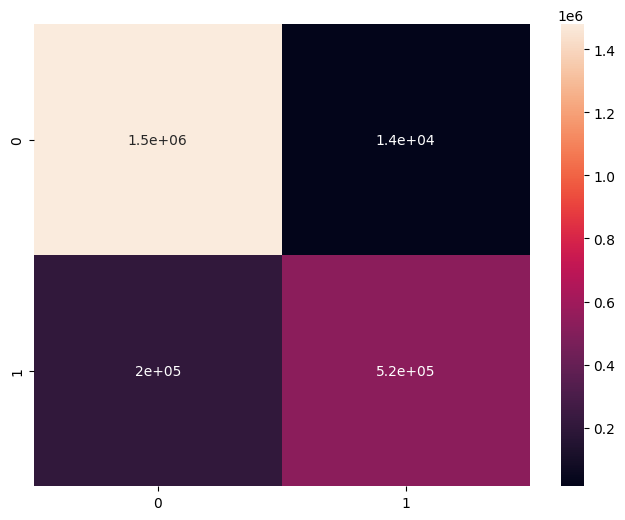

In [21]:
metrics(y_test, y_pred)

In [22]:
test['iForest'].value_counts()

iForest
0    1493608
1     728192
Name: count, dtype: int64

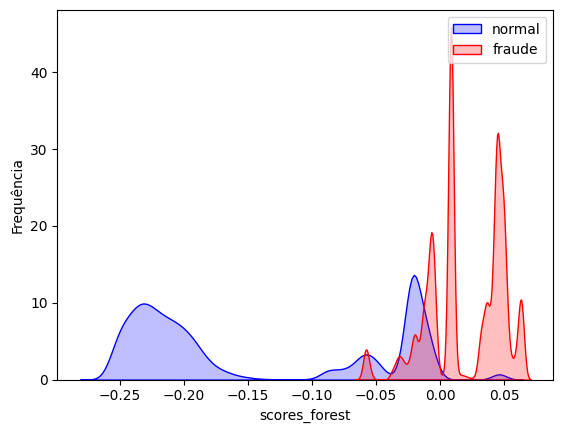

In [23]:
g = sns.kdeplot(test["scores_forest"][(test["target"] == 0) & (test["scores_forest"].notnull())], color="Blue", fill = True)
g = sns.kdeplot(test["scores_forest"][(test["target"] == 1) & (test["scores_forest"].notnull())], color="Red", fill = True)

g.set_xlabel("scores_forest")
g.set_ylabel("Frequência")
g = g.legend(['normal', 'fraude'])

0º percentil: -0.73
0.01º percentil: -0.72
1º percentil: -0.72
10º percentil: -0.70
25º percentil: -0.68
50º percentil: -0.52
75º percentil: -0.43
90º percentil: -0.41
100º percentil: -0.38


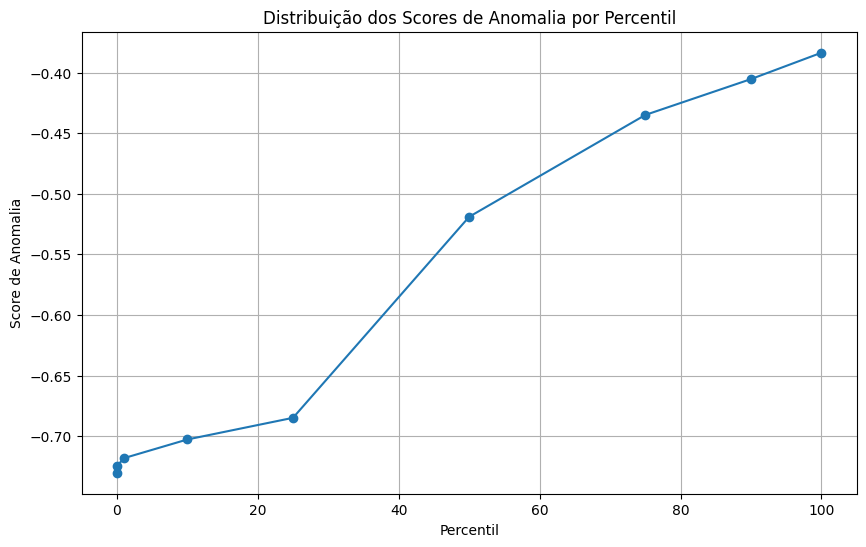

In [24]:
percentiles = [0, 0.01, 1, 10, 25, 50, 75, 90, 100]

# Calcular os valores dos percentis
percentile_values = np.percentile(train['scores_forest'], percentiles)

# Mostrar os percentis e seus valores correspondentes
for p, value in zip(percentiles, percentile_values):
    print(f"{p}º percentil: {value:.2f}")

# Plotar os percentis
plt.figure(figsize=(10, 6))
plt.plot(percentiles, percentile_values, marker='o', linestyle='-')
plt.xlabel('Percentil')
plt.ylabel('Score de Anomalia')
plt.title('Distribuição dos Scores de Anomalia por Percentil')
plt.grid(True)
plt.show()

<Axes: xlabel='scores_forest', ylabel='Density'>

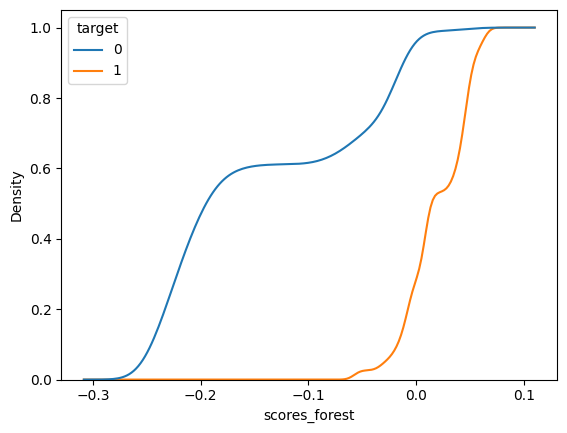

In [25]:
sns.kdeplot(
    data=test.sample(frac=0.01), x="scores_forest", hue=test.target,
    cumulative=True, common_norm=False, common_grid=True,
)

In [25]:
with open('./models/pipeline_iForest.pkl', 'wb') as file: 
    pickle.dump(best_model_iforest, file)

## Algorithms Pyod

https://pyod.readthedocs.io/en/latest/

#### PCA

In [14]:
# Definir a grade de hiperparâmetros para o PCA
param_grid = { 
    'contamination': [0.05, 0.01, 0.001],
    'n_components':[7, 5, 3],
    'n_selected_components':[None]

}
                
estimator_class = PCA

# Configurar TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

# fold_ratios = [0.5, 0.6, 0.7, 0.8] 

In [15]:
estimator_class

pyod.models.pca.PCA

In [16]:
development.shape

(8887177, 10)

In [17]:
results_df_pca = cross_validation(estimator_class, param_grid, development, tscv, VARS, scikit = False, random_state=42)

taxa de anomalias: 0.16380006427238528
taxa de anomalias: 0.07884349314112829
taxa de anomalias: 0.6981308798205415
taxa de anomalias: 0.16380006427238528
taxa de anomalias: 0.07884349314112829
taxa de anomalias: 0.6981308798205415
taxa de anomalias: 0.16380006427238528
taxa de anomalias: 0.07884349314112829
taxa de anomalias: 0.6981308798205415
taxa de anomalias: 0.16380006427238528
taxa de anomalias: 0.07884349314112829
taxa de anomalias: 0.6981308798205415
taxa de anomalias: 0.16380006427238528
taxa de anomalias: 0.07884349314112829
taxa de anomalias: 0.6981308798205415
taxa de anomalias: 0.16380006427238528
taxa de anomalias: 0.07884349314112829
taxa de anomalias: 0.6981308798205415
taxa de anomalias: 0.16380006427238528
taxa de anomalias: 0.07884349314112829
taxa de anomalias: 0.6981308798205415
taxa de anomalias: 0.16380006427238528
taxa de anomalias: 0.07884349314112829
taxa de anomalias: 0.6981308798205415
taxa de anomalias: 0.16380006427238528
taxa de anomalias: 0.078843493141

In [18]:
results_df_pca

,params,fold_scores,mean_test_f1_score,std_test_f1_score,mean_test_specificity,std_test_specificity,mean_test_precision,std_test_precision,mean_test_recall,std_test_recall,mean_test_roc_auc,std_test_roc_auc,mean_fit_time,std_fit_time,mean_score_time,std_score_time
0,"{'contamination': 0.05, 'n_components': 7, 'n_...","{'test_f1_scores': [0.0, 0.0, 0.85560064030642...",0.285200,0.403334,0.073125,0.103414,0.249214,0.352442,0.333333,0.471405,0.536563,0.051707,3.091669,1.550567,0.615462,0.073614
1,"{'contamination': 0.05, 'n_components': 5, 'n_...","{'test_f1_scores': [0.4826060376699368, 0.2224...",0.520505,0.260241,0.542005,0.331427,0.622035,0.365103,0.772956,0.321088,0.657481,0.036060,6.992033,2.844574,0.737819,0.160342
2,"{'contamination': 0.05, 'n_components': 3, 'n_...","{'test_f1_scores': [0.8515825822181525, 0.2224...",0.644398,0.298400,0.547762,0.326197,0.625589,0.367785,0.914118,0.121455,0.730940,0.104302,5.491262,2.373944,0.459764,0.031802
3,"{'contamination': 0.01, 'n_components': 7, 'n_...","{'test_f1_scores': [0.0, 0.0, 1.0], 'test_spec...",0.333333,0.471405,0.333333,0.471405,0.333333,0.471405,0.333333,0.471405,0.666667,0.235702,3.013296,1.154494,0.683155,0.064390
4,"{'contamination': 0.01, 'n_components': 5, 'n_...","{'test_f1_scores': [0.0, 0.3384916528747559, 1...",0.446164,0.415287,0.555153,0.415632,0.401242,0.431478,0.666667,0.471405,0.777576,0.207816,5.902370,3.190512,0.572463,0.068689
5,"{'contamination': 0.01, 'n_components': 3, 'n_...","{'test_f1_scores': [0.0, 0.33811010475827424, ...",0.446037,0.415320,0.554963,0.415582,0.401150,0.431520,0.666667,0.471405,0.777481,0.207791,6.150827,2.707178,0.564781,0.087274
6,"{'contamination': 0.001, 'n_components': 7, 'n...","{'test_f1_scores': [0.0, 0.0, 1.0], 'test_spec...",0.333333,0.471405,0.333333,0.471405,0.333333,0.471405,0.333333,0.471405,0.666667,0.235702,2.209509,1.048516,0.605342,0.054548
7,"{'contamination': 0.001, 'n_components': 5, 'n...","{'test_f1_scores': [0.0, 0.33850800549190946, ...",0.446169,0.415286,0.555161,0.415635,0.401246,0.431476,0.666667,0.471405,0.777581,0.207817,5.776988,3.027525,0.477072,0.012743
8,"{'contamination': 0.001, 'n_components': 3, 'n...","{'test_f1_scores': [0.0, 0.33819888157710565, ...",0.446066,0.415312,0.555007,0.415594,0.401171,0.431510,0.666667,0.471405,0.777503,0.207797,5.626897,2.965547,0.547615,0.162425


In [19]:
results_df_pca['fold_scores'][0]

{'test_f1_scores': [0.0, 0.0, 0.8556006403064292],
 'test_specificities': [0, 0, 0.21937524135555717],
 'test_precisions': [0.0, 0.0, 0.7476416629029996],
 'test_recalls': [0.0, 0.0, 1.0],
 'test_roc_auc': [0.5, 0.5, 0.6096876206777786],
 'fit_times': [1.6237080097198486, 2.414902687072754, 5.236395835876465],
 'score_times': [0.5625863075256348, 0.5642349720001221, 0.7195634841918945]}

In [20]:
results_df_pca['fold_scores'][1]

{'test_f1_scores': [0.4826060376699368,
  0.22241916745494136,
  0.8564888387754404],
 'test_specificities': [0.9994951191260502,
  0.4015391230418935,
  0.22498139978022666],
 'test_precisions': [0.9919818094782192,
  0.12512464321326633,
  0.7489991071519112],
 'test_recalls': [0.318869013271783, 1.0, 1.0],
 'test_roc_auc': [0.6591820661989166, 0.7007695615209467, 0.6124906998901134],
 'fit_times': [3.8511292934417725, 6.3856892585754395, 10.739280939102173],
 'score_times': [0.9196486473083496, 0.7642395496368408, 0.5295686721801758]}

In [21]:
results_df_pca['fold_scores'][2]

{'test_f1_scores': [0.8515825822181525,
  0.22241916745494136,
  0.8591911842092144],
 'test_specificities': [0.9997814694724695,
  0.4015391230418935,
  0.24196686700731038],
 'test_precisions': [0.9984994696401315,
  0.12512464321326633,
  0.7531421324208828],
 'test_recalls': [0.7423542989036354, 1.0, 1.0],
 'test_roc_auc': [0.8710678841880525, 0.7007695615209467, 0.6209834335036553],
 'fit_times': [2.5090062618255615, 5.6470887660980225, 8.317690372467041],
 'score_times': [0.4348256587982178, 0.4398198127746582, 0.504645824432373]}

In [22]:
# Identificar a melhor combinação de hiperparâmetros
best_params_idx = results_df_pca['mean_test_roc_auc'].idxmax()
best_params_idx
best_params = results_df_pca.loc[best_params_idx]

print("\nMelhores parâmetros encontrados:", best_params['params'])

print("\nMétricas:", best_params)


Melhores parâmetros encontrados: {'contamination': 0.001, 'n_components': 5, 'n_selected_components': None}

Métricas: params                   {'contamination': 0.001, 'n_components': 5, 'n...
fold_scores              {'test_f1_scores': [0.0, 0.33850800549190946, ...
mean_test_f1_score                                                0.446169
std_test_f1_score                                                 0.415286
mean_test_specificity                                             0.555161
std_test_specificity                                              0.415635
mean_test_precision                                               0.401246
std_test_precision                                                0.431476
mean_test_recall                                                  0.666667
std_test_recall                                                   0.471405
mean_test_roc_auc                                                 0.777581
std_test_roc_auc                                       

In [23]:
estimator = estimator_class(random_state=42, **best_params['params'])

best_model_pca = Pipeline([
            ('scaler', StandardScaler()),
            ('to_dataframe', ToDataFrameTransformer(columns=VARS)), 
            ('estimator', estimator)
        ])

best_model_pca.fit(train_no_anomalies[VARS])

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['P-PDG', 'P-TPT', 'T-TPT',
                                                 'P-MON-CKP', 'T-JUS-CKP',
                                                 'P-JUS-CKGL', 'QGL'])),
                ('estimator',
                 PCA(contamination=0.001, copy=True, iterated_power='auto', n_components=5,
  n_selected_components=None, random_state=42, standardization=True,
  svd_solver='auto', tol=0.0, weighted=True, whiten=False))])

In [24]:
scale_pca = best_model_pca[0]

In [25]:
media = scale_pca.mean_

desvio_padrao = scale_pca.scale_

print("Média calculada pelo StandardScaler:", media)
print("Desvio padrão calculado pelo StandardScaler:", desvio_padrao)

Média calculada pelo StandardScaler: [1.01713733e+07 1.32058831e+07 1.17294754e+02 4.47385646e+06
 7.32985921e+01 2.17328886e+06 1.96035520e-06]
Desvio padrão calculado pelo StandardScaler: [1.88216312e+07 5.09831214e+06 8.36684233e-01 3.90022108e+06
 1.16327041e+01 1.56808619e+06 2.93207414e-04]


In [26]:
y_pred = best_model_pca.predict(test[VARS])
y_test = test.target.values

In [27]:
test['pca']  = y_test
test['scores_pca']= best_model_pca.decision_function(test[VARS])

In [28]:
train['scores_pca'] = best_model_pca.decision_function(train[VARS])

Classification Report: 
               precision    recall  f1-score   support

           0    1.00000   0.99021   0.99508   1493608
           1    0.98032   1.00000   0.99006    728192

    accuracy                        0.99342   2221800
   macro avg    0.99016   0.99511   0.99257   2221800
weighted avg    0.99355   0.99342   0.99344   2221800

Specificity: 0.9902102827515653
Gini:  0.9902102827515653
ROC AUC::  0.9951051413757827


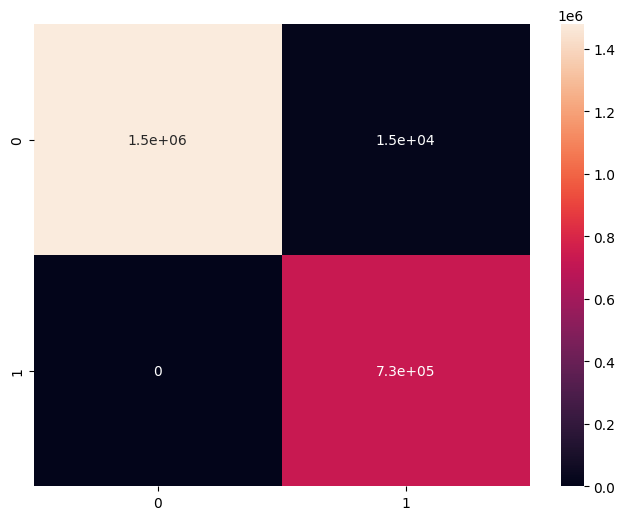

In [29]:
metrics(y_test, y_pred)

<Axes: xlabel='scores_pca', ylabel='Density'>

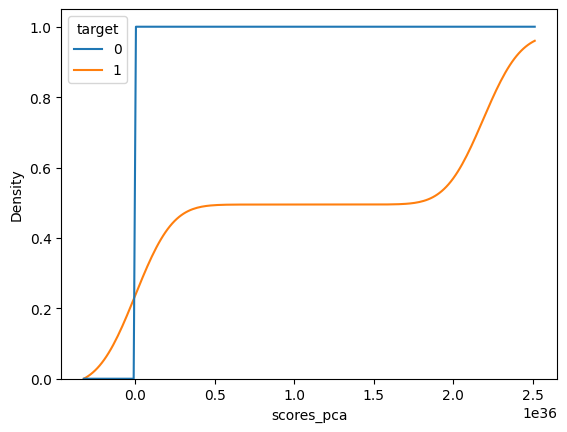

In [30]:
sns.kdeplot(
    data=test.sample(frac=0.01), x="scores_pca", hue=test.target,
    cumulative=True, common_norm=False, common_grid=True,
)

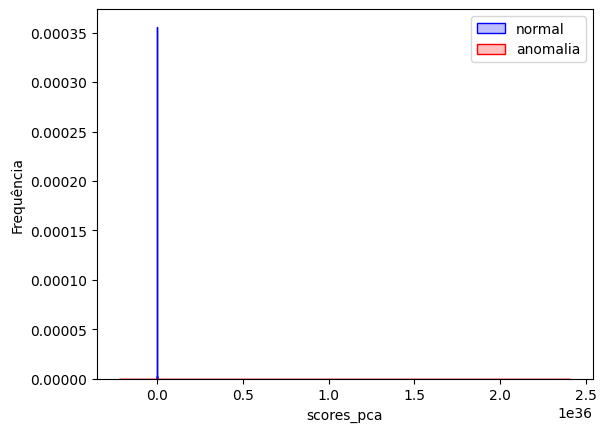

In [31]:
g = sns.kdeplot(test["scores_pca"][(test["target"] == 0) & (test["scores_pca"].notnull())], color="Blue", fill = True)
g = sns.kdeplot(test["scores_pca"][(test["target"] == 1) & (test["scores_pca"].notnull())], ax =g, color="Red", fill= True)

g.set_xlabel("scores_pca")
g.set_ylabel("Frequência")
g = g.legend(['normal', 'anomalia'])

In [32]:
with open('./models/pipeline_PCA.pkl', 'wb') as file: 
    pickle.dump(best_model_pca, file)

#### LODA

In [20]:
# Definir a grade de hiperparâmetros para o PCA
param_grid = { 
    'contamination': [0.05, 0.01, 0.001],
    'n_bins':[500, 1000, 2000],
    'n_random_cuts':[100, 500, 1000]

}
                
estimator_class = LODA

# Configurar TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

In [18]:
results_df_loda = cross_validation(estimator_class, param_grid, development, tscv, VARS, scikit = False, random_state=None)

taxa de anomalias: 0.16380006427238528
taxa de anomalias: 0.07884349314112829
taxa de anomalias: 0.6981308798205415
taxa de anomalias: 0.16380006427238528
taxa de anomalias: 0.07884349314112829
taxa de anomalias: 0.6981308798205415
taxa de anomalias: 0.16380006427238528
taxa de anomalias: 0.07884349314112829
taxa de anomalias: 0.6981308798205415
taxa de anomalias: 0.16380006427238528
taxa de anomalias: 0.07884349314112829
taxa de anomalias: 0.6981308798205415
taxa de anomalias: 0.16380006427238528
taxa de anomalias: 0.07884349314112829
taxa de anomalias: 0.6981308798205415
taxa de anomalias: 0.16380006427238528
taxa de anomalias: 0.07884349314112829
taxa de anomalias: 0.6981308798205415
taxa de anomalias: 0.16380006427238528
taxa de anomalias: 0.07884349314112829
taxa de anomalias: 0.6981308798205415
taxa de anomalias: 0.16380006427238528
taxa de anomalias: 0.07884349314112829
taxa de anomalias: 0.6981308798205415
taxa de anomalias: 0.16380006427238528
taxa de anomalias: 0.078843493141

In [22]:
results_df_loda 

,params,fold_scores,mean_test_f1_score,std_test_f1_score,mean_test_specificity,std_test_specificity,mean_test_precision,std_test_precision,mean_test_recall,std_test_recall,mean_test_roc_auc,std_test_roc_auc,mean_fit_time,std_fit_time,mean_score_time,std_score_time
0,"{'contamination': 0.05, 'n_bins': 500, 'n_rand...","{'test_f1_scores': [0.2814917601414536, 0.2224...",0.446762,0.276558,0.165559,0.171306,0.335900,0.271197,1.000000,0.000000,0.582779,0.085653,20.187006,9.988630,9.216328,0.931411
1,"{'contamination': 0.05, 'n_bins': 500, 'n_rand...","{'test_f1_scores': [0.2814917601414536, 0.2223...",0.446359,0.276010,0.162917,0.172371,0.335312,0.270381,1.000000,0.000000,0.581459,0.086186,91.803122,44.220475,45.887806,1.908271
2,"{'contamination': 0.05, 'n_bins': 500, 'n_rand...","{'test_f1_scores': [0.2814917601414536, 0.2223...",0.452225,0.284300,0.201042,0.163830,0.344102,0.282806,1.000000,0.000000,0.600521,0.081915,182.100768,93.109245,87.317151,3.589885
3,"{'contamination': 0.05, 'n_bins': 1000, 'n_ran...","{'test_f1_scores': [0.2814917601414536, 0.2220...",0.446124,0.275908,0.161685,0.172262,0.335053,0.270157,1.000000,0.000000,0.580843,0.086131,18.815317,8.103868,9.540092,0.891441
4,"{'contamination': 0.05, 'n_bins': 1000, 'n_ran...","{'test_f1_scores': [0.2814917601414536, 0.2219...",0.443694,0.272549,0.145509,0.180598,0.331519,0.265208,1.000000,0.000000,0.572755,0.090299,97.772286,46.265967,44.599379,0.796924
5,"{'contamination': 0.05, 'n_bins': 1000, 'n_ran...","{'test_f1_scores': [0.2814917601414536, 0.2222...",0.447103,0.277143,0.167955,0.170065,0.336443,0.272030,1.000000,0.000000,0.583977,0.085033,192.050260,93.997668,91.651616,1.412759
6,"{'contamination': 0.05, 'n_bins': 2000, 'n_ran...","{'test_f1_scores': [0.2814917601414536, 0.2221...",0.446575,0.276451,0.164545,0.171289,0.335683,0.270990,1.000000,0.000000,0.582273,0.085644,20.574219,9.915465,10.074960,1.201929
7,"{'contamination': 0.05, 'n_bins': 2000, 'n_ran...","{'test_f1_scores': [0.2814917601414536, 0.2222...",0.442051,0.270028,0.134037,0.188782,0.329064,0.261613,1.000000,0.000000,0.567018,0.094391,97.453832,48.768504,51.702844,3.287232
8,"{'contamination': 0.05, 'n_bins': 2000, 'n_ran...","{'test_f1_scores': [0.2814917601414536, 0.2221...",0.450486,0.282012,0.190134,0.164147,0.341535,0.279283,1.000000,0.000000,0.595067,0.082073,197.575292,98.995165,96.661034,3.643783
9,"{'contamination': 0.01, 'n_bins': 500, 'n_rand...","{'test_f1_scores': [0.2763281920947347, 0.3162...",0.495315,0.281903,0.491230,0.408437,0.658035,0.359719,0.719159,0.375719,0.605194,0.099498,19.104915,8.980261,9.225854,0.974324


In [47]:
# Identificar a melhor combinação de hiperparâmetros
best_params_idx = results_df_loda['mean_test_roc_auc'].idxmax()
best_params_idx
best_params = results_df_loda.loc[best_params_idx]

print("\nMelhores parâmetros encontrados:", best_params['params'])

print("\nMétricas:", best_params)


Melhores parâmetros encontrados: {'contamination': 0.001, 'n_bins': 2000, 'n_random_cuts': 500}

Métricas: params                   {'contamination': 0.001, 'n_bins': 2000, 'n_ra...
fold_scores              {'test_f1_scores': [0.27885651869941686, 0.560...
mean_test_f1_score                                                0.575395
std_test_f1_score                                                 0.248336
mean_test_specificity                                               0.4248
std_test_specificity                                              0.353683
mean_test_precision                                               0.449404
std_test_precision                                                0.262275
mean_test_recall                                                  0.996374
std_test_recall                                                   0.005128
mean_test_roc_auc                                                 0.710587
std_test_roc_auc                                                  0

In [21]:
best_params = {'contamination': 0.001, 'n_bins': 2000, 'n_random_cuts': 500}

In [22]:
estimator = estimator_class(**best_params['params'])

best_model_loda = Pipeline([
            ('scaler', StandardScaler()),
            ('to_dataframe', ToDataFrameTransformer(columns=VARS)), 
            ('estimator', estimator)
        ])

best_model_loda.fit(train_no_anomalies[VARS])

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['P-PDG', 'P-TPT', 'T-TPT',
                                                 'P-MON-CKP', 'T-JUS-CKP',
                                                 'P-JUS-CKGL', 'QGL'])),
                ('estimator',
                 LODA(contamination=0.001, n_bins=2000, n_random_cuts=500))])

In [23]:
y_pred = best_model_loda.predict(test[VARS])
y_test = test.target.values

In [24]:
test['loda']  = y_test
test['scores_loda']= best_model_loda.decision_function(test[VARS])

Classification Report: 
               precision    recall  f1-score   support

           0    1.00000   0.98588   0.99289   1493608
           1    0.97185   1.00000   0.98572    728192

    accuracy                        0.99051   2221800
   macro avg    0.98592   0.99294   0.98931   2221800
weighted avg    0.99077   0.99051   0.99054   2221800

Specificity: 0.9858764816471256
Gini:  0.9858764816471255
ROC AUC::  0.9929382408235627


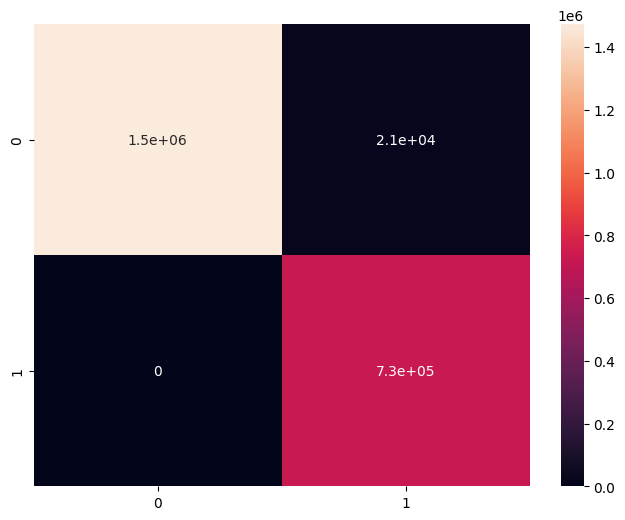

In [25]:
metrics(y_test, y_pred)

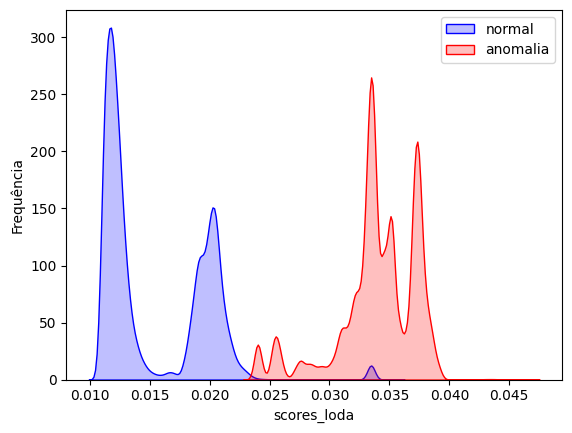

In [66]:
g = sns.kdeplot(test["scores_loda"][(test["target"] == 0) & (test["scores_loda"].notnull())], color="Blue", fill = True)
g = sns.kdeplot(test["scores_loda"][(test["target"] == 1) & (test["scores_loda"].notnull())], ax =g, color="Red", fill= True)

g.set_xlabel("scores_loda")
g.set_ylabel("Frequência")
g = g.legend(['normal', 'anomalia'])

In [52]:
# filename= './models/LODA.sav'
# joblib.dump(clf_LODA, filename)

with open('./models/pipeline_LODA.pkl', 'wb') as file: 
    pickle.dump(best_model_loda, file)

### SGDOneClassSVM

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDOneClassSVM.html#sklearn.linear_model.SGDOneClassSVM

In [11]:
param_grid = { 
    'nu': [0.001, 0.01, 0.05],
    'eta0': [0.01, 0.05, 0.1],
    'learning_rate':['constant', 'optimal', 'invscaling', 'adaptive']
}

kernels = ['rbf', 'poly', 'sigmoid', 'linear']
                
estimator_class = SGDOneClassSVM

# Configurar TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

In [16]:
results_df_svm =  cross_validation_ocsvm(estimator_class, param_grid,  development, tscv, VARS, scikit = True, random_state=42, kernels=kernels)

Treinando com kernel: rbf e parâmetros: {'nu': 0.001, 'eta0': 0.01, 'learning_rate': 'constant'}
taxa de anomalias: 0.16380006427238528
taxa de anomalias: 0.07884349314112829
taxa de anomalias: 0.6981308798205415
Treinando com kernel: poly e parâmetros: {'nu': 0.001, 'eta0': 0.01, 'learning_rate': 'constant'}
taxa de anomalias: 0.16380006427238528
taxa de anomalias: 0.07884349314112829
taxa de anomalias: 0.6981308798205415
Treinando com kernel: sigmoid e parâmetros: {'nu': 0.001, 'eta0': 0.01, 'learning_rate': 'constant'}
taxa de anomalias: 0.16380006427238528
taxa de anomalias: 0.07884349314112829
taxa de anomalias: 0.6981308798205415
Treinando com kernel: linear e parâmetros: {'nu': 0.001, 'eta0': 0.01, 'learning_rate': 'constant'}
taxa de anomalias: 0.16380006427238528
taxa de anomalias: 0.07884349314112829
taxa de anomalias: 0.6981308798205415
Treinando com kernel: rbf e parâmetros: {'nu': 0.001, 'eta0': 0.01, 'learning_rate': 'optimal'}
taxa de anomalias: 0.16380006427238528
taxa 

In [54]:
# results_df_svm = cross_validation(estimator_class, param_grid, development, tscv, VARS, scikit = True, random_state=42)

taxa de anomalias: 0.16380006427238528
taxa de anomalias: 0.07884349314112829
taxa de anomalias: 0.6981308798205415
taxa de anomalias: 0.16380006427238528
taxa de anomalias: 0.07884349314112829
taxa de anomalias: 0.6981308798205415
taxa de anomalias: 0.16380006427238528
taxa de anomalias: 0.07884349314112829
taxa de anomalias: 0.6981308798205415


In [19]:
results_df_svm

,kernel,params,fold_scores,mean_test_f1_score,std_test_f1_score,mean_test_specificity,std_test_specificity,mean_test_precision,std_test_precision,mean_test_recall,std_test_recall,mean_test_roc_auc,std_test_roc_auc,mean_fit_time,std_fit_time,mean_score_time,std_score_time
0,rbf,"{'nu': 0.001, 'eta0': 0.01, 'learning_rate': '...","{'test_f1_scores': [0.2730417182263069, 0.0, 0...",0.091014,0.128713,0.000000,0.000000,0.053004,0.074959,0.321745,0.455016,0.494206,0.008194,19.138902,9.564765,9.218007,1.691062
1,poly,"{'nu': 0.001, 'eta0': 0.01, 'learning_rate': '...","{'test_f1_scores': [0.2730417182263069, 0.0, 0...",0.208947,0.356985,0.342197,0.465516,0.193664,0.365207,0.322038,0.450375,0.498784,0.272176,22.688513,11.693232,11.048849,2.206661
2,sigmoid,"{'nu': 0.001, 'eta0': 0.01, 'learning_rate': '...","{'test_f1_scores': [0.2730417182263069, 0.0, 0...",0.309033,0.385061,0.523197,0.466795,0.342199,0.448919,0.356394,0.409989,0.550907,0.268527,21.505678,11.147509,9.682063,2.733823
3,linear,"{'nu': 0.001, 'eta0': 0.01, 'learning_rate': '...","{'test_f1_scores': [0.2730417182263069, 0.0, 0...",0.292732,0.345779,0.531102,0.454731,0.356919,0.445372,0.371052,0.414717,0.576077,0.246344,19.442581,10.833062,8.407591,3.276024
4,rbf,"{'nu': 0.001, 'eta0': 0.01, 'learning_rate': '...","{'test_f1_scores': [0.2808914040856214, 0.0, 0...",0.093630,0.132413,0.000000,0.000000,0.054487,0.077056,0.332506,0.470235,0.499586,0.000585,18.905784,8.064074,10.229966,3.220517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,linear,"{'nu': 0.05, 'eta0': 0.1, 'learning_rate': 'in...","{'test_f1_scores': [0.2814917601414536, 0.2223...",0.331011,0.352162,0.625740,0.390265,0.369543,0.418419,0.446975,0.431981,0.578024,0.246915,19.488802,11.826600,7.900841,4.040047
140,rbf,"{'nu': 0.05, 'eta0': 0.1, 'learning_rate': 'ad...","{'test_f1_scores': [0.2814917601414536, 0.2223...",0.493992,0.343200,0.432639,0.366734,0.415367,0.383480,1.000000,0.000000,0.716320,0.183367,65.949254,33.353786,7.999381,1.682653
141,poly,"{'nu': 0.05, 'eta0': 0.1, 'learning_rate': 'ad...","{'test_f1_scores': [0.2814917601414536, 0.2223...",0.410216,0.413877,0.544738,0.424068,0.374714,0.431336,0.660568,0.463562,0.602653,0.326072,71.265059,37.875206,11.395234,3.790480
142,sigmoid,"{'nu': 0.05, 'eta0': 0.1, 'learning_rate': 'ad...","{'test_f1_scores': [0.2814917601414536, 0.2223...",0.390463,0.368279,0.641458,0.377637,0.380611,0.397606,0.564311,0.434496,0.602884,0.272881,68.843176,36.605666,9.662899,3.954577


In [56]:
results_df_svm['fold_scores'][0]

{'test_f1_scores': [0.2808914040856214, 0.0, 0.0],
 'test_specificities': [0.0, 0, 0],
 'test_precisions': [0.16346007075538602, 0.0, 0.0],
 'test_recalls': [0.9975187536064628, 0.0, 0.0],
 'test_roc_auc': [0.4987593768032314, 0.5, 0.5],
 'fit_times': [6.552067041397095, 20.696141719818115, 27.470924854278564],
 'score_times': [6.686821222305298, 6.899582386016846, 10.433214664459229]}

In [57]:
results_df_svm['fold_scores'][1]

{'test_f1_scores': [0.28144722985299286, 0.33795257543808205, 1.0],
 'test_specificities': [0.0, 0.6646519627483363, 1.0],
 'test_precisions': [0.16377484722470403, 0.20333509768962188, 1.0],
 'test_recalls': [0.9998158986618306, 1.0, 1.0],
 'test_roc_auc': [0.4999079493309153, 0.8323259813741681, 1.0],
 'fit_times': [6.010940074920654, 16.091143131256104, 32.98112750053406],
 'score_times': [6.257837772369385, 6.017680883407593, 10.921159505844116]}

In [58]:
results_df_svm['fold_scores'][2]

{'test_f1_scores': [0.2814917601414536,
  0.2223392751069976,
  0.9771090705103371],
 'test_specificities': [0, 0.4012625695048421, 0.8916401144491278],
 'test_precisions': [0.16380006427238528,
  0.12507407740606985,
  0.9552426777289273],
 'test_recalls': [1.0, 1.0, 1.0],
 'test_roc_auc': [0.5, 0.7006312847524211, 0.9458200572245639],
 'fit_times': [6.22400975227356, 16.306185483932495, 26.960662364959717],
 'score_times': [5.903992414474487, 5.8656463623046875, 13.004470109939575]}

In [20]:
# Identificar a melhor combinação de hiperparâmetros
best_params_idx = results_df_svm['mean_test_roc_auc'].idxmax()
best_params_idx
best_params = results_df_svm.loc[best_params_idx]

print("\nMelhores parâmetros encontrados:", best_params['params'])

print("\nMétricas:", best_params)


Melhores parâmetros encontrados: {'nu': 0.01, 'eta0': 0.1, 'learning_rate': 'adaptive'}

Métricas: kernel                                                                 rbf
params                   {'nu': 0.01, 'eta0': 0.1, 'learning_rate': 'ad...
fold_scores              {'test_f1_scores': [0.28148444935690853, 0.338...
mean_test_f1_score                                                 0.53984
std_test_f1_score                                                   0.3262
mean_test_specificity                                             0.554925
std_test_specificity                                              0.415572
mean_test_precision                                                0.45573
std_test_precision                                                0.385196
mean_test_recall                                                   0.99999
std_test_recall                                                   0.000014
mean_test_roc_auc                                                 0.777458


In [59]:
# Identificar a melhor combinação de hiperparâmetros
best_params_idx = results_df_svm['mean_test_roc_auc'].idxmax()
best_params_idx
best_params = results_df_svm.loc[best_params_idx]

print("\nMelhores parâmetros encontrados:", best_params['params'])

print("\nMétricas:", best_params)


Melhores parâmetros encontrados: {'nu': 0.01}

Métricas: params                                                        {'nu': 0.01}
fold_scores              {'test_f1_scores': [0.28144722985299286, 0.337...
mean_test_f1_score                                                  0.5398
std_test_f1_score                                                 0.326227
mean_test_specificity                                             0.554884
std_test_specificity                                              0.415561
mean_test_precision                                               0.455703
std_test_precision                                                0.385215
mean_test_recall                                                  0.999939
std_test_recall                                                   0.000087
mean_test_roc_auc                                                 0.777411
std_test_roc_auc                                                  0.207822
mean_fit_time                             

In [12]:
best_params = {'nu': 0.01, 'eta0': 0.1, 'learning_rate': 'adaptive'}

In [13]:
transform = Nystroem(gamma=None, random_state=42)
estimator = estimator_class(random_state=42, **best_params)
estimator = make_pipeline(transform, estimator)


best_model_svm = Pipeline([
            ('scaler', StandardScaler()),
            ('to_dataframe', ToDataFrameTransformer(columns=VARS)), 
            ('estimator', estimator)
        ])

best_model_svm.fit(train_no_anomalies[VARS])

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['P-PDG', 'P-TPT', 'T-TPT',
                                                 'P-MON-CKP', 'T-JUS-CKP',
                                                 'P-JUS-CKGL', 'QGL'])),
                ('estimator',
                 Pipeline(steps=[('nystroem', Nystroem(random_state=42)),
                                 ('sgdoneclasssvm',
                                  SGDOneClassSVM(eta0=0.1,
                                                 learning_rate='adaptive',
                                                 nu=0.01,
                                                 random_state=42))]))])

In [60]:
transform = Nystroem(gamma=None, random_state=42)
estimator = estimator_class(random_state=42, **best_params['params'])
estimator = make_pipeline(transform, estimator)


best_model_svm = Pipeline([
            ('scaler', StandardScaler()),
            ('to_dataframe', ToDataFrameTransformer(columns=VARS)), 
            ('estimator', estimator)
        ])

best_model_svm.fit(train_no_anomalies[VARS])

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['P-PDG', 'P-TPT', 'T-TPT',
                                                 'P-MON-CKP', 'T-JUS-CKP',
                                                 'P-JUS-CKGL', 'QGL'])),
                ('estimator',
                 Pipeline(steps=[('nystroem', Nystroem(random_state=42)),
                                 ('sgdoneclasssvm',
                                  SGDOneClassSVM(nu=0.01, random_state=42))]))])

In [14]:
y_pred = best_model_svm.predict(test[VARS])
y_pred = np.where(y_pred == -1, 1, 0)  


y_test = test.target.values

In [15]:
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [16]:
test['scores_ocsvm']= -best_model_svm.decision_function(test[VARS])

Classification Report: 
               precision    recall  f1-score   support

           0    1.00000   0.86369   0.92686   1493608
           1    0.78150   1.00000   0.87735    728192

    accuracy                        0.90836   2221800
   macro avg    0.89075   0.93184   0.90211   2221800
weighted avg    0.92839   0.90836   0.91063   2221800

Specificity: 0.8636891339628604
Gini:  0.8636891339628603
ROC AUC::  0.9318445669814301


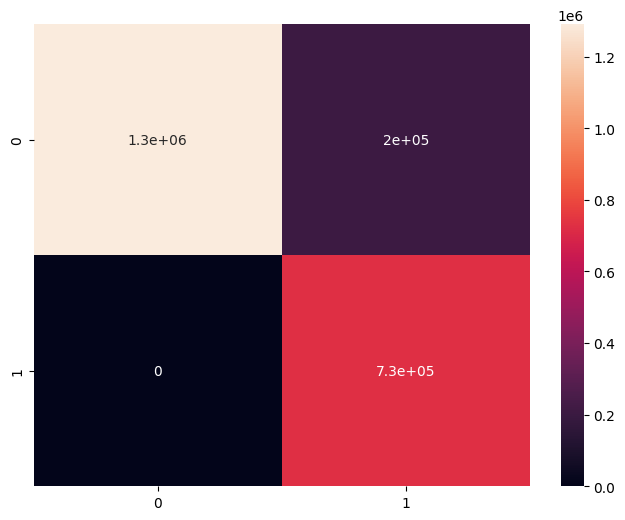

In [17]:
metrics(y_test, y_pred)

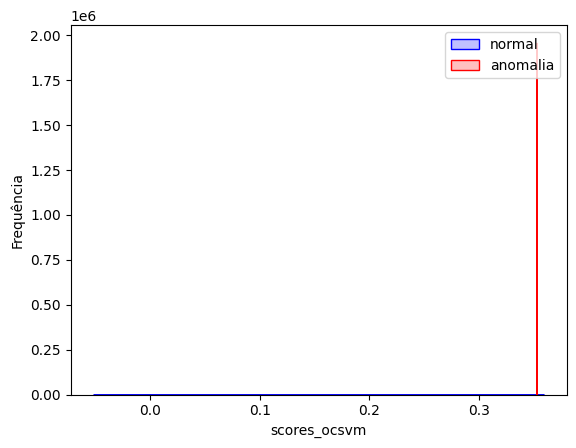

In [18]:
g = sns.kdeplot(test["scores_ocsvm"][(test["target"] == 0) & (test["scores_ocsvm"].notnull())], color="Blue", fill = True)
g = sns.kdeplot(test["scores_ocsvm"][(test["target"] == 1) & (test["scores_ocsvm"].notnull())], ax =g, color="Red", fill= True)

g.set_xlabel("scores_ocsvm")
g.set_ylabel("Frequência")
g = g.legend(['normal', 'anomalia'])

In [19]:
with open('./models/pipeline_SGDOSVM.pkl', 'wb') as file: 
    pickle.dump(best_model_svm, file)

In [ ]:
# ### Local Outlier Factor
# lof = LocalOutlierFactor(n_neighbors=15, novelty=True, p=2, metric = 'minkowski', contamination=0.33)
# inicio = time.time()
# lof.fit(X_train_p[VARS])
# fim = time.time()
# print("time train")
# print((fim - inicio)/60)
# with open('./models/LOF_temp.pkl', 'wb') as file: 
#     pickle.dump(lof, file)
# test['score_LOF']=lof.decision_function(X_test_p[VARS])
# predictions=lof.predict(X_test_p[VARS])
# binary_predictions = np.where(predictions == -1, 1, 0)
# test['LOF'] = binary_predictions
# train['score_LOF']=lof.decision_function(X_train_p[VARS])
# predictions =lof.predict(X_train_p[VARS])
# binary_predictions = np.where(predictions == -1, 1, 0)
# train['LOF'] =  binary_predictions
# metrics(train.target, train.LOF)
# metrics(test.target, test.LOF)
# filename= './models/LOF.sav'
# joblib.dump(lof, filename)


# with open('./models/LOF.pkl', 'wb') as file: 
#     pickle.dump(lof, file)

In [ ]:
# from sklearn.model_selection import TimeSeriesSplit

# for poço_id, poço_data in df.groupby('poço_id'):
#     poço_data = poço_data.sort_values(by='date')
#     tscv = TimeSeriesSplit(n_splits=3)
#     for train_index, test_index in tscv.split(poço_data):
#         train, test = poço_data.iloc[train_index], poço_data.iloc[test_index]
        
#         model = IsolationForest(contamination=0.1, random_state=42)
#         model.fit(train[['value']])
        
#         test['anomaly_score'] = model.decision_function(test[['value']])
#         test['anomaly'] = model.predict(test[['value']])
        
#         results.append(test[['date', 'poço_id', 'value', 'anomaly_score', 'anomaly']])


In [ ]:
# # Ordenar os dados por poço e por data para garantir a ordem temporal
# df = data.sort_values(by=['well', 'timestamp'])

# # Configuração do GroupKFold
# gkf = GroupKFold(n_splits=2)


# for train_index, test_index in gkf.split(df, groups=df['well']):
#     train, test = df.iloc[train_index], df.iloc[test_index]
    
#     print(f'Treino Poços: {train.well.unique()}')
#     print(f'Teste Poços: {test.well.unique()}')
#     print(f'Tamanho do treino: {len(train)}')
#     print(f'Tamanho do teste: {len(test)}')



# # Separar dados por poço
# train_pocos, test_pocos = train_test_split(data['well'].unique(), test_size=0.2, random_state=42)

# train = data[data['well'].isin(train_pocos)].sort_values(by=['well', 'timestamp'])
# test = data[data['well'].isin(test_pocos)].sort_values(by=['well', 'timestamp'])

# print(f'Treino Poços: {train_pocos}')
# print(f'Teste Poços: {test_pocos}')
# print(f'Tamanho do treino: {len(train)}')
# print(f'Tamanho do teste: {len(test)}')